In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [23]:
#Read in technical indicators
dow_tech = pd.read_csv('Dow_technical_indicator_labels.csv') 

In [24]:
#Generating training data
#Columns D-F tests
test_year_dates = ['2018-08-01','2019-08-30']
t1year = ['2017-07-03','2018-07-30']
t5year = ['2013-07-01','2018-07-30']

# train_type should be ['1_year','5_year','all']
def get_recent_test_train(df, train_type):
    try:
        df = df.set_index('Date')
    except:
        pass
    test = df.loc[test_year_dates[0]:test_year_dates[1]]
    if train_type == '1_year':
        train = df.loc[t1year[0]:t1year[1]]
    elif train_type == '5_year':
        train = df.loc[t5year[0]:t5year[1]]
    elif train_type == 'all':
        train = df.loc[:t1year[1]]
    else:
        print("train_type must be one of the following:")
        print('1_year, ','5_year, ','or all')
        return(0,0)
    return(train, test)

In [25]:
def convert_data(df, lback, len_data):
    features_set = []
    labels = []
    days = lback
    for i in range(days, len_data):
        #print (i)
        features_set.append(df[i-days:i].values)
        #print (features_set)
        labels.append(df['Labels'][i:i+1].values)
    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], -1))

    features_set = np.nan_to_num(features_set)
    labels = np.nan_to_num(labels)
    labels = np.transpose(labels)
    #the labels data needs to be a one-hot encoding
    b = np.zeros((labels.size, int(labels.max())+1))
    labels = labels.astype(np.int32)
    #print (labels[0:50])
    b[np.arange(labels.size),labels] = 1
    labels = b
    print(labels.shape)
    return (features_set, labels)

In [26]:
#Importing Dataset
#do we want open, close, volume, etc? 
#at some point will want to include technical indicators?
def process_data(csv_input, csv_labels, train_type, lback):
    #read in csv file
    prices = csv_input #pd.read_csv(csv_input) 
    print (prices.head())
    prices_processed = prices[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'keltner_indicator', 
                  'bbands_indicator', 'ichimoku_label', 'macd_indicator', 'ease_label', 
                'stochastic_label', 'rsi_label', 'cmf_label']]
    prices_processed.index = prices['Date']
    #prices_processed = prices_processed.drop(['Date', 'Unnamed: 0'], axis=1)
    print (prices_processed.head())
    #Normalize all the feature columns
    x = prices_processed.values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    print ('x: ', x)
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'keltner_indicator', 
                  'bbands_indicator', 'ichimoku_label', 'macd_indicator', 'ease_label', 
                'stochastic_label', 'rsi_label', 'cmf_label']
    prices_scaled = df
    prices_scaled.index = prices['Date']
    #ADD CLASSIFICATION COLUMN (1/-1/0)
    labels = pd.read_csv(csv_labels, header=None)
    labels.index = prices['Date'][3:-1]
    labels.columns = ['Labels']
    prices_scaled['Labels'] = labels
    for index, row in prices_scaled.iterrows():
        if -1 < row['Labels'] and row['Labels'] < 1:
            row['Labels'] = 1
        elif row['Labels'] == -1:
            row['Labels'] = 0
        elif row['Labels'] == 1:
            row['Labels'] = 2
    #Split into training and testing
    (train, test) = get_recent_test_train(prices_scaled, train_type) 
    #print ('train data: {}, test data: {}'.format(train.head(), test.head()))
    #(y_train, y_test) = get_recent_test_train(labels, train_type)
    #print ('train labels: {}, test labels: {}'.format(y_train, y_test))
    #print (dow_prices_scaled.head(), labels.head())
    (X_train, y_train) = convert_data(train, lback, len(train))
    (X_test, y_test) = convert_data(test, lback, len(test))
    return (X_train, X_test, y_train, y_test)
#start_date = pd.datetime(1985,1,30)
#end_date   = pd.datetime(2019,9,30)
#dow_prices = pd.read_csv('data/Dow_Jones_Data_Daily.csv')
#dow_prices_processed = dow_prices[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] #['Close']
#dow_prices_processed.index = dow_prices['Date']
#print (dow_prices_processed.head())
(X_train, X_test, y_train, y_test) = process_data(dow_tech, 'Output_files/Dow_daily_labels.csv', '5_year', 60)
print ('X_train: {}, X_test: {}, y_train: {}, y_test: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))




   Unnamed: 0        Date         Open         High          Low        Close  \
0           0  1985-01-29  1277.719971  1295.489990  1266.890015  1292.619995   
1           1  1985-01-30  1297.369995  1305.099976  1278.930054  1287.880005   
2           2  1985-01-31  1283.239990  1293.400024  1272.640015  1286.770020   
3           3  1985-02-01  1276.939941  1286.109985  1269.770020  1277.719971   
4           4  1985-02-04  1272.079956  1294.939941  1268.989990  1290.079956   

     Adj Close    Volume  volume_cmf    volume_em  ...  cmf_low  \
0  1292.619995  13560000    0.799301     0.000000  ...    -0.05   
1  1287.880005  16820000    0.181804  1684.243358  ...    -0.05   
2  1286.770020  14070000    0.238612 -1327.193941  ...    -0.05   
3  1277.719971  10980000    0.186011  -755.986339  ...    -0.05   
4  1290.079956  11630000    0.262218   898.087641  ...    -0.05   

   keltner_indicator  bbands_indicator  ichimoku_label  macd_indicator  \
0                  1               0

In [ ]:
'''#Data Normalization all feature columns
from sklearn import preprocessing

x = dow_prices_processed.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
dow_prices_scaled = df
dow_prices_scaled.index = dow_prices['Date']
#print (dow_prices_scaled.head())
#print (dow_prices_scaled.shape)

#ADD CLASSIFICATION COLUMN (1/-1/0)
labels = pd.read_csv('Output_files/Dow_daily_labels.csv', header=None)
#print (labels)
labels.index = dow_prices['Date'][3:-1]
labels.columns = ['Labels']
#print (dow_prices_scaled.head(), labels.head())
dow_prices_scaled['Labels'] = labels
for index, row in dow_prices_scaled.iterrows():
    if -1 < row['Labels'] and row['Labels'] < 1:
        row['Labels'] = 1
    elif row['Labels'] == -1:
        row['Labels'] = 0
    elif row['Labels'] == 1:
        row['Labels'] = 2
#dow_prices_scaled'''




In [ ]:
'''#Convert Training Data to Right Shape

#LABELS NEEDS TO BE THE -1/1/0 VALUES
features_set = []
labels = []
days = 120
for i in range(days, 8739):
    #print (i)
    features_set.append(dow_prices_scaled[i-days:i].values)
    #print (features_set)
    labels.append(dow_prices_scaled['Labels'][i:i+1].values)
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 7))

features_set = np.nan_to_num(features_set)
labels = np.nan_to_num(labels)
labels = np.transpose(labels)
#the labels data needs to be a one-hot encoding
b = np.zeros((labels.size, int(labels.max())+1))
labels = labels.astype(np.int32)
#print (labels[0:50])
b[np.arange(labels.size),labels] = 1
labels = b
print(labels.shape)'''

In [ ]:
'''#Split dataset into training and testing
(X_train, X_test) = get_recent_test_train(features_set, '5_year')
(y_train, y_test) = get_recent_test_train(labels, '5_year')
print ('X_train: {}, X_test: {}, y_train: {}, y_test: {}'.format(X_train.head(), X_test.head(), y_train.head(), y_test.head()))
#X_train,X_validation,X_test = X[:int(X.shape[0]*0.70)],X[int(X.shape[0]*0.70):int(X.shape[0]*0.85)], X[int(X.shape[0]*0.85):]
#y_train,y_validation, y_test = y[:int(y.shape[0]*0.70)],y[int(y.shape[0]*0.70):int(y.shape[0]*0.85)], y[int(y.shape[0]*0.85):]
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
'''



In [27]:
#Training the LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD

Using TensorFlow backend.
/Users/sarahgage/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sarahgage/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sarahgage/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sarahgage/anaconda3/lib/python3.6/sit

In [31]:
model = Sequential()
#Create LSTM and Dropout Layers
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 15)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,activation='relu'))
model.add(Dropout(0.2))

#Create dense layer
model.add(Dense(units = 3, activation='softmax'))
#Model compilation
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 150, validation_data=(X_test, y_test), batch_size = int(0.05*len(X_train)))
#model.predict(features_set)

Instructions for updating:
Use tf.cast instead.
Train on 1220 samples, validate on 213 samples
Epoch 1/150
1220/1220 [==============================] - 4s 3ms/step - loss: 1.0880 - accuracy: 0.3811 - val_loss: 1.0764 - val_accuracy: 0.3897
Epoch 2/150
1220/1220 [==============================] - 2s 2ms/step - loss: 1.0838 - accuracy: 0.3820 - val_loss: 1.0696 - val_accuracy: 0.3897
Epoch 3/150
1220/1220 [==============================] - 2s 2ms/step - loss: 1.0827 - accuracy: 0.3844 - val_loss: 1.0569 - val_accuracy: 0.3944
Epoch 4/150
1220/1220 [==============================] - 2s 2ms/step - loss: 1.0826 - accuracy: 0.3893 - val_loss: 1.0762 - val_accuracy: 0.3897
Epoch 5/150
1220/1220 [==============================] - 2s 2ms/step - loss: 1.0790 - accuracy: 0.3820 - val_loss: 1.0739 - val_accuracy: 0.3897
Epoch 6/150
1220/1220 [==============================] - 3s 2ms/step - loss: 1.0733 - accuracy: 0.3795 - val_loss: 1.0766 - val_accuracy: 0.3897
Epoch 7/150
1220/1220 [============

1220/1220 [==============================] - 2s 2ms/step - loss: 0.6520 - accuracy: 0.7500 - val_loss: 1.0660 - val_accuracy: 0.6103
Epoch 56/150
1220/1220 [==============================] - 2s 2ms/step - loss: 0.6469 - accuracy: 0.7484 - val_loss: 1.0230 - val_accuracy: 0.5728
Epoch 57/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.6537 - accuracy: 0.7484 - val_loss: 1.0202 - val_accuracy: 0.5869
Epoch 58/150
1220/1220 [==============================] - 2s 2ms/step - loss: 0.6547 - accuracy: 0.7615 - val_loss: 0.9795 - val_accuracy: 0.5915
Epoch 59/150
1220/1220 [==============================] - 2s 2ms/step - loss: 0.6307 - accuracy: 0.7557 - val_loss: 0.9964 - val_accuracy: 0.5493
Epoch 60/150
1220/1220 [==============================] - 2s 2ms/step - loss: 0.6513 - accuracy: 0.7484 - val_loss: 0.9565 - val_accuracy: 0.5869
Epoch 61/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.6186 - accuracy: 0.7574 - val_loss: 1.1281 - val_accuracy

1220/1220 [==============================] - 2s 2ms/step - loss: 0.4817 - accuracy: 0.7959 - val_loss: 2.8800 - val_accuracy: 0.4554
Epoch 112/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4748 - accuracy: 0.7934 - val_loss: 2.1123 - val_accuracy: 0.5023
Epoch 113/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4521 - accuracy: 0.8049 - val_loss: 2.3381 - val_accuracy: 0.5399
Epoch 114/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4653 - accuracy: 0.8016 - val_loss: 1.8502 - val_accuracy: 0.4977
Epoch 115/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4710 - accuracy: 0.8025 - val_loss: 1.7237 - val_accuracy: 0.5117
Epoch 116/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4735 - accuracy: 0.8057 - val_loss: 1.6084 - val_accuracy: 0.5305
Epoch 117/150
1220/1220 [==============================] - 3s 2ms/step - loss: 0.4649 - accuracy: 0.8066 - val_loss: 1.7120 - val_ac

Test loss: 2.672218360811332, Test accuracy: 0.43192487955093384


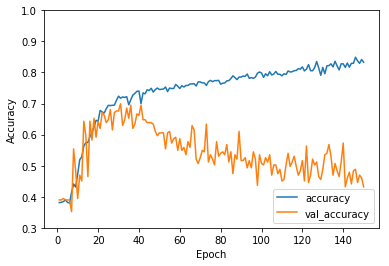

In [32]:
#Evaluating the model
epoch = np.linspace(1,150, 150)
#print (epoch)
#print (history.history['val_accuracy'])
plt.plot(epoch, history.history['accuracy'], label='accuracy')
plt.plot(epoch, history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print ('Test loss: {}, Test accuracy: {}'.format(test_loss, test_acc))

###### 